# Задание 12
## Обнаружение аномалий

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

### Задание 12.1

In [2]:
# выгруз данных
data = pd.read_csv('diy.txt')
data

ClientID  Recency  Frequency  Monetary_Q  Monetary_A
0      client13166      682          2          23        2705
1       client1239       35         43         219       42161
2      client30041      190         25         133       16057
3      client36276      289          4          12        4614
4      client14136      217          6          36       35870
...            ...      ...        ...         ...         ...
42741  client35593        1          1           3       12797
42742  client22822        1          1           4         536
42743  client23138        1          1          33        6269
42744  client32589        1          1          46       12372
42745  client25258        1          1           5         945

[42746 rows x 5 columns]

In [3]:
# выбор частоты > 1 и суммы
df = data.drop('ClientID', axis=1)[data['Frequency'] > 1][['Monetary_A', 'Frequency']]
df

Monetary_A  Frequency
0            2705          2
1           42161         43
2           16057         25
3            4614          4
4           35870          6
...           ...        ...
42656        5328          2
42660        1893          2
42677        6425          2
42687          90          2
42688        6410          2

[29887 rows x 2 columns]

In [4]:
# стандартизация

scaler = StandardScaler()
new_cols = scaler.fit_transform(df)
df_std = pd.DataFrame(new_cols, columns = df.columns)
df_std

Monetary_A  Frequency
0       -0.443535  -0.638675
1        0.597724   3.443679
2       -0.091171   1.651426
3       -0.393156  -0.439536
4        0.431702  -0.240397
...           ...        ...
29882   -0.374313  -0.638675
29883   -0.464964  -0.638675
29884   -0.345363  -0.638675
29885   -0.512546  -0.638675
29886   -0.345759  -0.638675

[29887 rows x 2 columns]

#### LocalOutlierFactor

Поиск аномалий (novelty=False)

In [7]:
# обучение и предсказание
x = df_std[['Monetary_A', 'Frequency']]
clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
pred = clf.fit_predict(x)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
# число аномалий в выборке
list(pred).count(-1)

75

In [9]:
# фильтрация аномалий
df_std['outlier'] = pred
df_new = df_std.loc[df_std.outlier == 1]   # датасет без аномалий
outliers = df_std.loc[df_std.outlier == -1]   # только аномалии
df_new

Monetary_A  Frequency  outlier
0       -0.443535  -0.638675        1
1        0.597724   3.443679        1
2       -0.091171   1.651426        1
3       -0.393156  -0.439536        1
4        0.431702  -0.240397        1
...           ...        ...      ...
29882   -0.374313  -0.638675        1
29883   -0.464964  -0.638675        1
29884   -0.345363  -0.638675        1
29885   -0.512546  -0.638675        1
29886   -0.345759  -0.638675        1

[29812 rows x 3 columns]

Поиск аномалий (novelty=True)

In [10]:
# обучение второй модели
x2 = df_new[['Monetary_A', 'Frequency']]

# модель по обнаружению аномалий
clf_n = LocalOutlierFactor(n_neighbors=20, novelty=True)

# обучение
clf_n.fit(x2)

# предсказание (анамалия или нет)
pred2 = clf_n.predict(outliers[['Monetary_A', 'Frequency']])
pred2

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])

Модель правильно идентиицировала все аномалии.

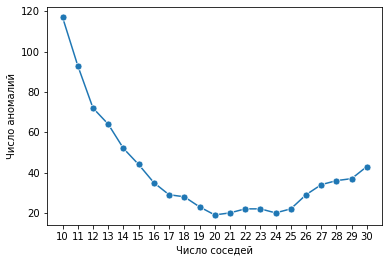

In [9]:
# поиск оптимального числа соседей
neighbors = list(range(10, 31))
c = []
for i in neighbors:
    clf = LocalOutlierFactor(n_neighbors=i, novelty=True)
    clf.fit(x2)
    pred = clf.predict(df_new[['Monetary_A', 'Frequency']])
    c.append(list(pred).count(-1))

sns.lineplot(y=c, x=neighbors, marker='o',markersize=7)
plt.xticks(neighbors)
plt.xlabel('Число соседей')
plt.ylabel('Число аномалий')

plt.show()

Оптимальное число соседей по графику: 20

In [11]:
# поиск аномалий в датасете без аномалий
pred3 = clf_n.predict(df_new[['Monetary_A', 'Frequency']])

# число аномалий
list(pred3).count(-1)

19

Модель находит 19 аномалий там, где их не должно быть.

#### IsolationForest

In [12]:
# обучение модели и предсказание
isolf = IsolationForest(contamination=75/len(x))
pred3 = isolf.fit_predict(x)
pred3

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
# число аномалий в первоначальной выборке
list(pred3).count(-1)

75

### Задание 12.2

In [13]:
data2 = pd.read_csv('banks.txt', encoding='cp1251')
data2

Bank  Assents  OwnCapital  IndFunds  NBSLoans  IndLoans
0          «Авангард»   122109       20440     35443     32728      3319
1             «Аверс»   110741       24410     34918     13613      4924
2             «Агора»     1114         356       274       351       206
3    «Агропромкредит»    18774        2332     12047      6484       903
4           «Агророс»     7917        1157      3564      1909       492
..                ...      ...         ...       ...       ...       ...
366      Ю БИ ЭС Банк     7117        4164         0        43         0
367     Юг-Инвестбанк    12504        1431      7407      6637      2238
368               ЮМК     5024        2117         0      2585       235
369    Юникредит-банк  1315550      197369    267400    665780    170748
370       Яринтербанк     2820         362      1307      1732       221

[371 rows x 6 columns]

In [15]:
data2.isnull().mean()

Bank          0.0
Assents       0.0
OwnCapital    0.0
IndFunds      0.0
NBSLoans      0.0
IndLoans      0.0
dtype: float64

Стандартизация

In [16]:
# удаление столбца с банками
data2 = data2.drop(columns="Bank")

# стандартизация
scaler = StandardScaler()
new_cols2 = scaler.fit_transform(data2)
df_std2 = pd.DataFrame(new_cols2, columns = data2.columns)
df_std2

Assents  OwnCapital  IndFunds  NBSLoans  IndLoans
0   -0.071960   -0.036578 -0.065488 -0.097648 -0.107472
1   -0.077810   -0.022560 -0.066141 -0.112365 -0.103954
2   -0.134225   -0.107495 -0.109261 -0.122575 -0.114295
3   -0.125137   -0.100518 -0.094608 -0.117853 -0.112768
4   -0.130724   -0.104667 -0.105166 -0.121375 -0.113669
..        ...         ...       ...       ...       ...
366 -0.131135   -0.094049 -0.109602 -0.122812 -0.114747
367 -0.128363   -0.103699 -0.100383 -0.117735 -0.109841
368 -0.132213   -0.101277 -0.109602 -0.120855 -0.114232
369  0.542193    0.588163  0.223215  0.389733  0.259514
370 -0.133347   -0.107474 -0.107975 -0.121512 -0.114263

[371 rows x 5 columns]

#### LocalOutlierFactor

Поиск аномалий (novelty=False)

In [17]:
x = df_std2
clf = LocalOutlierFactor(n_neighbors=20, novelty=False)
pred = clf.fit_predict(x)

# число аномалий в выборке
list(pred).count(-1)

77

In [18]:
# фильтрация аномалий
df_std2['outlier'] = pred
df_new2 = df_std2.loc[df_std2.outlier == 1]   # датасет без аномалий
outliers = df_std2.loc[df_std2.outlier == -1]   # только аномалии
df_new2

Assents  OwnCapital  IndFunds  NBSLoans  IndLoans  outlier
0   -0.071960   -0.036578 -0.065488 -0.097648 -0.107472        1
1   -0.077810   -0.022560 -0.066141 -0.112365 -0.103954        1
2   -0.134225   -0.107495 -0.109261 -0.122575 -0.114295        1
3   -0.125137   -0.100518 -0.094608 -0.117853 -0.112768        1
4   -0.130724   -0.104667 -0.105166 -0.121375 -0.113669        1
..        ...         ...       ...       ...       ...      ...
364 -0.105893   -0.088336 -0.098665 -0.116329 -0.109951        1
365 -0.126984   -0.084716 -0.104245 -0.116114 -0.109024        1
367 -0.128363   -0.103699 -0.100383 -0.117735 -0.109841        1
368 -0.132213   -0.101277 -0.109602 -0.120855 -0.114232        1
370 -0.133347   -0.107474 -0.107975 -0.121512 -0.114263        1

[294 rows x 6 columns]

In [19]:
outliers

Assents  OwnCapital  IndFunds  NBSLoans  IndLoans  outlier
39  -0.129118   -0.104020 -0.108180 -0.121246 -0.114583       -1
44  -0.123542   -0.103600 -0.108836 -0.122817 -0.114723       -1
48  -0.116368   -0.058015 -0.109602 -0.122820 -0.114747       -1
72   0.029749    0.200961 -0.107956  0.063348 -0.106812       -1
75  -0.127134   -0.095641 -0.096416 -0.114708 -0.084003       -1
..        ...         ...       ...       ...       ...      ...
349 -0.125055   -0.105977 -0.103570 -0.122817 -0.114664       -1
351 -0.012223    0.117968  0.074086  0.007293  0.277661       -1
358 -0.122879   -0.114080 -0.090498 -0.116813 -0.113075       -1
366 -0.131135   -0.094049 -0.109602 -0.122812 -0.114747       -1
369  0.542193    0.588163  0.223215  0.389733  0.259514       -1

[77 rows x 6 columns]

Поиск аномалий (novelty=True)

In [20]:
# Поиск аномалий
# обучение второй модели
x2 = df_new2.loc[:, df_new2.columns != 'outlier']

# модель по обнаружению аномалий
clf_n = LocalOutlierFactor(n_neighbors=20, novelty=True)

# обучение
clf_n.fit(x2)

# предсказание (анамалия или нет)
pred2 = clf_n.predict(outliers.loc[:, outliers.columns != 'outlier'])
pred2

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [21]:
# обучение модели и предсказание
isolf = IsolationForest(contamination=75/len(x))
pred = isolf.fit_predict(x)

In [22]:
list(pred).count(-1)

75